## Residual Networks Models
### Installation and Import Checks

In [1]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# Plotting
import matplotlib.pyplot as plt

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. Splits for training and testing 80/20 ratio

In [4]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded if not already
y_output = to_categorical(y_output, num_classes=4)  # Assuming there are 4 classes

# Resizes images to 224 x 224 for optimal size for VGG models
# x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a list to store the augmented images and their labels
augmented_images = []
augmented_labels = []

# Generate augmented images
for img, label in zip(x_input, y_output):
    img = img.reshape((1,) + img.shape)  # Reshape image for ImageDataGenerator
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        i += 1
        if i >= 1:  # Generate 4 augmented images for each original image
            break

# Convert the lists to numpy arrays
x_input_augmented = np.array(augmented_images)
y_output_augmented = np.array(augmented_labels)

# Combine the original and augmented data
x_input_combined = np.concatenate((x_input, x_input_augmented), axis=0)
y_output_combined = np.concatenate((y_output, y_output_augmented), axis=0)

# Split the combined data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_combined, y_output_combined, test_size=0.2, random_state=42)

# Print new dimensions of the data
print(f'Augmented X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Augmented Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Testing Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

Augmented X Training Data
Number of Rows: 3072
Pixel Dimensions: 224x224x3

Augmented Y Training Data
Number of Rows: 3072
Number of Classes: 4
X Testing Data
Number of Rows: 768
Pixel Dimensions: 224x224x3

Y Testing Data
Number of Rows: 768
Number of Classes: 4


In [5]:
# # Load the data
# x_input = np.load('prepared_data/x_input_combined.npy')
# y_output = np.load('prepared_data/y_output_combined.npy')

# # Ensure y is one-hot encoded if not already
# y_output = to_categorical(y_output, num_classes=4)  # Assuming there are 4 classes
# # Resizes images to 224 x 224 for optimal size for VGG models
# x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

# # Split the data into training and testing sets
# x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# # Printing Dimensions of data
# print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
# print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
# print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
# print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

### Loading and Defining ResNet Models

In [6]:
# Load the ResNet50 model pre-trained on ImageNet
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the ResNet50 base model
x = base_resnet50_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
x = Dropout(0.5)(x)
output_layer_resnet50 = Dense(4, activation='softmax')(x)  # 4 classes: no tumor, glioma, meningioma, pituitary

# Define the model
resnet50_brain_tumor_model = Model(inputs=base_resnet50_model.input, outputs=output_layer_resnet50)

# # Freeze the layers of the base model
for layer in base_resnet50_model.layers[-10:]:
    layer.trainable = False

In [7]:
# # Load the ResNet50 model pre-trained on ImageNet
# base_resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# # Adds global average pooling layer to reduce dimensions of features     
# pooled_output_152 = GlobalAveragePooling2D()(base_resnet152_model.output)
# # Adds a dense lyaer with 1024 neurons using RELU activation function     
# dense_layer_152 = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pooled_output_152)
# # Add dropout layer with 50% dropout rate for regularization to avoid overfitting 
# dropout_layer_152 = Dropout(0.6)(dense_layer_152)
# # Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
# output_layer_152 = Dense(4, activation='softmax')(dropout_layer_152)  # 4 classes: no tumor, glioma, meningioma, pituitary

# # Define the model
# resnet152_brain_tumor_model = Model(inputs=base_resnet152_model.input, outputs=output_layer_152)

# # # Freeze the layers of the base model
# # for layer in resnet152_brain_tumor_model.layers:
# #     layer.trainable = False

# # Freeze the initial layers of the base model, unfreeze the top layers for fine-tuning
# for layer in resnet152_brain_tumor_model.layers[:-20]:  # Unfreeze the last 20 layers
#     layer.trainable = False
# for layer in resnet152_brain_tumor_model.layers[-20:]:  # Freeze all the other layers
#     layer.trainable = True

### Training the ResNet Models

In [8]:
# Compile the model
# resnet50_brain_tumor_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_brain_tumor_model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_resnet50 = ModelCheckpoint('model_checkpoints/resnet50_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping_resnet50 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
# trained_resnet50_model = resnet50_brain_tumor_model.fit(train_generator, epochs=50, validation_data=val_generator, 
#                                                 callbacks=[checkpoint_resnet50, early_stopping_resnet50])
trained_resnet50_model = resnet50_brain_tumor_model.fit(x_input_train, y_output_train, epochs=30, validation_data=(x_input_test, y_output_test), 
                                                callbacks=[checkpoint_resnet50])

Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.7607
Epoch 1: val_loss improved from inf to 447.62302, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
96/96 [==============================] - 20s 167ms/step - loss: 0.7864 - accuracy: 0.7607 - val_loss: 447.6230 - val_accuracy: 0.2747
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.3093 - accuracy: 0.9111
Epoch 2: val_loss improved from 447.62302 to 8.37914, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
96/96 [==============================] - 15s 159ms/step - loss: 0.3093 - accuracy: 0.9111 - val_loss: 8.3791 - val_accuracy: 0.2253
Epoch 3/30
96/96 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.9040
Epoch 3: val_loss improved from 8.37914 to 3.25083, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
96/96 [==============================] - 16s 162ms/step - loss: 0.3215 - accuracy: 0.9040 - val

In [9]:
# # Compile the model
# # resnet152_brain_tumor_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# resnet152_brain_tumor_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# # Define callbacks
# checkpoint_resnet152 = ModelCheckpoint('model_checkpoints/resnet152_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping_resnet152 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# # Train the model
# trained_resnet152_model = resnet152_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
#                                                 callbacks=[checkpoint_resnet152, early_stopping_resnet152])

### Plotting ResNet Model Performances

In [10]:
def plot_model_performance(history, title):
    """
    Plot training and validation loss and accuracy.

    Parameters:
    - history: Keras History object
    - title: str, title of the plot
    """
    # Statistics
    for epoch in range(len(history.history['loss'])):
        print(f"Epoch {epoch + 1}:")
        print(f"  Training Loss: {history.history['loss'][epoch]:.4f}")
        print(f"  Validation Loss: {history.history['val_loss'][epoch]:.4f}")
        print(f"  Training Accuracy: {history.history['accuracy'][epoch]:.4f}")
        print(f"  Validation Accuracy: {history.history['val_accuracy'][epoch]:.4f}")
        print("-" * 40)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.legend()

    plt.suptitle(title)
    plt.show()

Epoch 1:
  Training Loss: 0.7864
  Validation Loss: 447.6230
  Training Accuracy: 0.7607
  Validation Accuracy: 0.2747
----------------------------------------
Epoch 2:
  Training Loss: 0.3093
  Validation Loss: 8.3791
  Training Accuracy: 0.9111
  Validation Accuracy: 0.2253
----------------------------------------
Epoch 3:
  Training Loss: 0.3215
  Validation Loss: 3.2508
  Training Accuracy: 0.9040
  Validation Accuracy: 0.2747
----------------------------------------
Epoch 4:
  Training Loss: 0.1507
  Validation Loss: 6.1700
  Training Accuracy: 0.9528
  Validation Accuracy: 0.2591
----------------------------------------
Epoch 5:
  Training Loss: 0.1781
  Validation Loss: 16.0874
  Training Accuracy: 0.9453
  Validation Accuracy: 0.1888
----------------------------------------
Epoch 6:
  Training Loss: 0.1426
  Validation Loss: 9.6576
  Training Accuracy: 0.9521
  Validation Accuracy: 0.2513
----------------------------------------
Epoch 7:
  Training Loss: 0.1092
  Validation Los

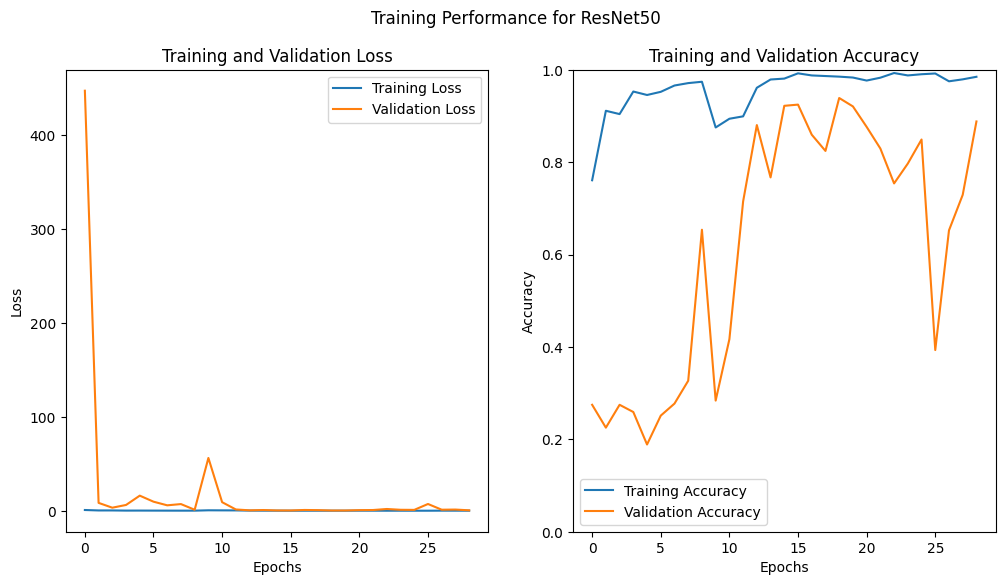

In [11]:
plot_model_performance(trained_resnet50_model, "Training Performance for ResNet50")
# plot_model_performance(trained_resnet152_model, "Training Performance for ResNet152")